# Loading libraries

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [5]:
from tensorflow.keras.layers import LSTM

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [7]:
import tensorflow_datasets as tfds

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import random

# Loading Dataset & Preprocessing

In [108]:
def GetDataset():
    data_list = []  # Create an empty list to store dataframes

    for i in range(1, 10):
        filename = f'Ip{i}.csv'
        num = pd.read_csv(filename)
        data_list.append(num)  # Append each dataframe to the list

    #data_list is a list object
    # Concatenate all dataframes in the list. because I want to use dropna and this command is only for dataframes
    concatenated_data = pd.concat(data_list, axis=0)
    data = concatenated_data.dropna()

    header = ['time', 'x', 'y', 'sai', 'x_dot', 'y_dot', 'sai_dot']
    data.columns = header

    return data

In [109]:
data_df = GetDataset()
data_df

,time,x,y,sai,x_dot,y_dot,sai_dot
1,0.0,0.000001,0.000001,0.000001,-0.017698,1.769800e-08,0.07854
2,1.0,-0.017678,0.000696,0.078541,-0.017643,1.388600e-03,0.07854
3,2.0,-0.035249,0.002775,0.157080,-0.017480,2.768500e-03,0.07854
4,3.0,-0.052602,0.006227,0.235620,-0.017209,4.131400e-03,0.07854
5,4.0,-0.069631,0.011030,0.314160,-0.016831,5.468900e-03,0.07854
...,...,...,...,...,...,...,...
12444,76.0,3.040000,0.104400,0.000000,0.040000,-5.124400e-02,0.00000
12445,77.0,3.080000,0.059334,0.000000,0.040000,-3.884500e-02,0.00000
12446,78.0,3.120000,0.026792,0.000000,0.040000,-2.620600e-02,0.00000
12447,79.0,3.160000,0.006976,0.000000,0.040000,-1.340600e-02,0.00000


<Axes: >

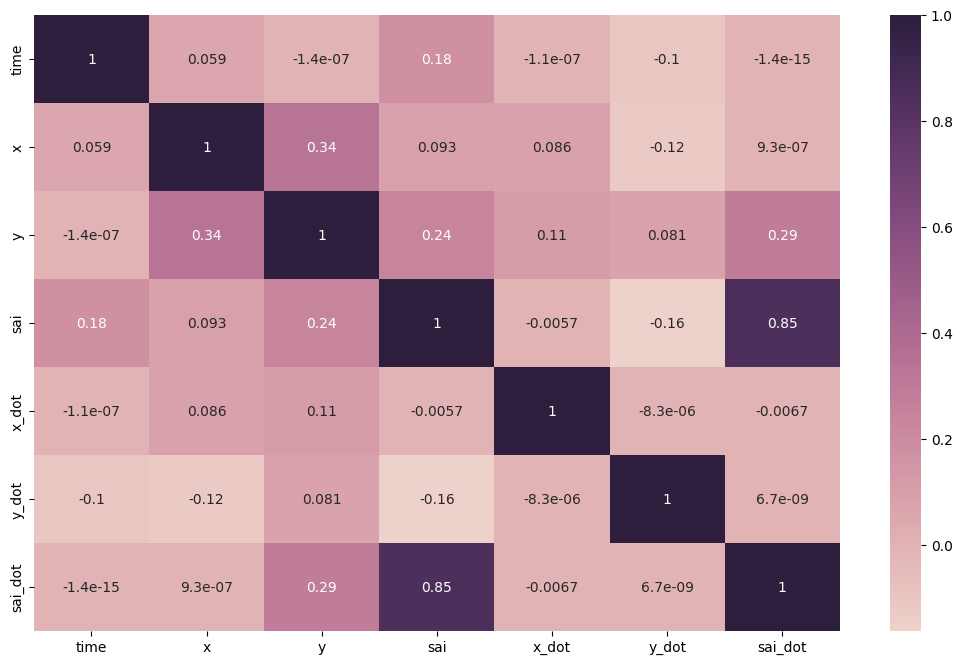

In [11]:
cor = data_df.corr()
plt.figure(figsize=(13,8))
sns.heatmap(cor,cmap=sns.cubehelix_palette(as_cmap=True),annot=True)

# window properties

In [110]:
def window_properties(input_width,shift,label_width):
  total_window_size = input_width + shift
  input_slice = slice(0, input_width)
  a = np.arange(total_window_size)
  input_indices = a[input_slice]

  label_start = total_window_size - label_width
  label_slice = slice(label_start, None)
  b = np.arange(total_window_size)
  label_indices = b[label_slice]

  return input_indices, label_indices,total_window_size, input_slice, label_slice

2 types of window_generation

In [111]:
input_width=80
shift=1
label_width=1
input_indices, label_indices, total_window_size, input_slice, label_slice = window_properties(input_width, shift, label_width)
input_indices, label_indices, total_window_size, input_slice, label_slice

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([80]),
 81,
 slice(0, 80, None),
 slice(80, None, None))

In [272]:
input_width=80
shift=1
label_width=80
input_indices, label_indices, total_window_size, input_slice, label_slice = window_properties(input_width, shift, label_width)
input_indices, label_indices, total_window_size, input_slice, label_slice

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80]),
 81,
 slice(0, 80, None),
 slice(1, None, None))

# window generator

In [14]:
def window_generator(data,total_window_size):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)
  numpy_arrays = [batch for batch in tfds.as_numpy(ds)]
  # Stack the NumPy arrays into a single array
  stacked_array = np.stack([batch[0] for batch in numpy_arrays])
  return stacked_array

In [273]:
df_tensors = window_generator(data_df,total_window_size)
df_tensors.shape

(109270, 81, 7)

In [ ]:
df_tensors[0,:80,0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79.], dtype=float32)

In [ ]:
df_tensors[0,80,0]

80.0

In [ ]:
df_tensors[0,:,0]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80.], dtype=float32)

In [ ]:
df_tensors[1,:,0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
       66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80.,  0.], dtype=float32)

In [ ]:
df_tensors[2,:,0]

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
       54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66.,
       67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79.,
       80.,  0.,  1.], dtype=float32)

In [ ]:
df_tensors[3,:,0]

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
       16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
       29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
       42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54.,
       55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67.,
       68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80.,
        0.,  1.,  2.], dtype=float32)

# split window

In [16]:
def split_window1(features, label_columns):
  inputs = features[:, input_slice, :]
  labels = features[:, label_slice, :]
  if label_columns is not None:
    labels = np.stack(
        [labels[:, :, column_indices[name]] for name in label_columns],
        axis=-1)

  return inputs, labels

In [274]:
label_columns = ['x']
column_indices = {name: i for i, name in enumerate(data_df.columns)}
if label_columns is not None:
      label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}

In [275]:

X, y = split_window1(df_tensors, label_columns)
X.shape, y.shape

((109270, 80, 7), (109270, 80, 1))

# plot

In [19]:
def plot(inputs_chosen_sample, labels_chosen_sample, model=None, plot_col='x', max_subplots=3):

  inputs = inputs_chosen_sample
  labels = labels_chosen_sample
  plt.figure(figsize=(12, 8))
  plot_col_index = column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if label_columns:
      label_col_index = label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
      predictions = model(inputs)
      plt.scatter(label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('k')

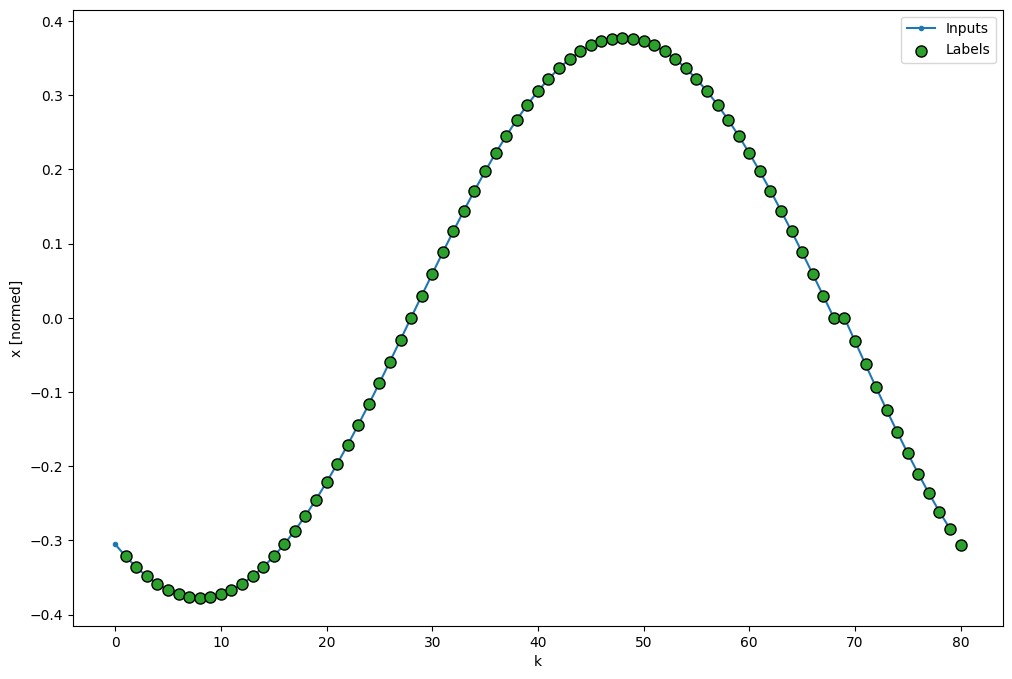

In [284]:

# Choose 1 random indices from X_test
random_indices = random.sample(range(X.shape[0]),1)
inputs_chosen_sample = X[random_indices]
labels_chosen_sample = y[random_indices]
plot(inputs_chosen_sample, labels_chosen_sample, model=None, plot_col='x', max_subplots=3)

# train-test-split

In [285]:
n = X.shape[0]
train_end = int(n * 0.6)
val_end = int(n * 0.75)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((65562, 80, 7),
 (65562, 80, 1),
 (16390, 80, 7),
 (16390, 80, 1),
 (27318, 80, 7),
 (27318, 80, 1))

# PreProcessing(Normalization)

In [286]:

# Use StandardScaler for normalization
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train.reshape((X_train.shape[0], -1)))
X_val_normalized = scaler.transform(X_val.reshape((X_val.shape[0], -1)))
X_test_normalized = scaler.transform(X_test.reshape((X_test.shape[0], -1)))

# Reshape back to the original shape if needed
X_train = X_train_normalized.reshape(X_train.shape)
X_val = X_val_normalized.reshape(X_val.shape)
X_test = X_test_normalized.reshape(X_test.shape)

# Check the shapes
print("Normalized shapes:")
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)

Normalized shapes:
X_train: (65562, 80, 7)
X_val: (16390, 80, 7)


# Compile & Fit the model

## These models gives data from 0 to 79 of each window and predicts 'x' for 80th step.

### Dense

In [72]:
from tensorflow.keras.layers import  Reshape

In [117]:
# Build the model
model = Sequential()
model.add(Dense(80, input_shape=(80, 7), activation='relu'))  # 1 input layer with 71 neurons
model.add(Dense(79, activation='relu'))  # 1 hidden layer with 71 neurons
model.add(Flatten())
model.add(Dense(1))  # 1 output layer with 1 neuron
model.add(Reshape((1, 1)))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 80, 80)            640       
                                                                 
 dense_19 (Dense)            (None, 80, 79)            6399      
                                                                 
 flatten_2 (Flatten)         (None, 6320)              0         
                                                                 
 dense_20 (Dense)            (None, 1)                 6321      
                                                                 
 reshape_3 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 13360 (52.19 KB)
Trainable params: 13360 (52.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics ='mse')

In [76]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

In [97]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
2049/2049 [==============================] - 10s 5ms/step - loss: 0.0444 - mse: 0.0444 - val_loss: 0.0353 - val_mse: 0.0353
Epoch 2/10
2049/2049 [==============================] - 9s 5ms/step - loss: 0.0180 - mse: 0.0180 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 3/10
2049/2049 [==============================] - 8s 4ms/step - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 4/10
2049/2049 [==============================] - 9s 4ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0259 - val_mse: 0.0259
Epoch 5/10
2049/2049 [==============================] - 9s 4ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 6/10
2049/2049 [==============================] - 10s 5ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0241 - val_mse: 0.0241
Epoch 7/10
2049/2049 [==============================] - 10s 5ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0278 - val_mse: 0.0278
Epoch 8/10
2049/2049 [==============================] - 10s

In [98]:
val_performance = model.evaluate(X_val, y_val)
test_performance = model.evaluate(X_test, y_test)

854/854 [==============================] - 4s 4ms/step - loss: 2.3912 - mse: 2.3912


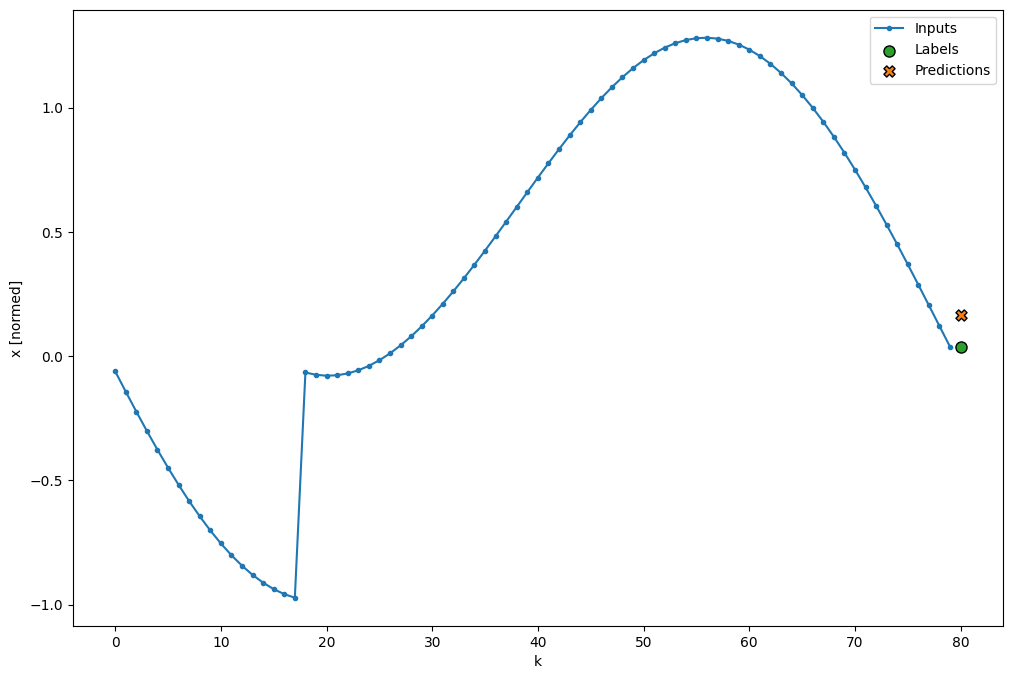

In [138]:
# Choose 1 random indices from X_test
random_indices = random.sample(range(X_test.shape[0]),1)
inputs_chosen_sample = X_test[random_indices]
labels_chosen_sample = y_test[random_indices]
plot(inputs_chosen_sample, labels_chosen_sample, model=model, plot_col='x', max_subplots=3)

In [139]:
y_pred = model.predict(X_test)


854/854 [==============================] - 2s 2ms/step


### Elman

In [ ]:
from tensorflow.keras.layers import  Reshape

In [145]:
# Build the model
model = Sequential()
model.add(keras.layers.SimpleRNN(80, input_shape=(80, 7), activation='relu'))  # 1 input layer with 71 neurons
model.add(Dense(79, activation='relu'))  # 1 hidden layer with 71 neurons
model.add(Flatten())
model.add(Dense(1))  # 1 output layer with 1 neuron
model.add(Reshape((1, 1)))  # Reshape the output to (None, 80, 1)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 80)                7040      
                                                                 
 dense_21 (Dense)            (None, 79)                6399      
                                                                 
 flatten_3 (Flatten)         (None, 79)                0         
                                                                 
 dense_22 (Dense)            (None, 1)                 80        
                                                                 
 reshape_4 (Reshape)         (None, 1, 1)              0         
                                                                 
Total params: 13519 (52.81 KB)
Trainable params: 13519 (52.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [146]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [147]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
2049/2049 [==============================] - 133s 54ms/step - loss: 0.0388 - val_loss: 0.0368
Epoch 2/10
2049/2049 [==============================] - 110s 54ms/step - loss: 0.0199 - val_loss: 0.0365
Epoch 3/10
2049/2049 [==============================] - 109s 53ms/step - loss: 0.0181 - val_loss: 0.0357
Epoch 4/10
2049/2049 [==============================] - 108s 53ms/step - loss: 0.0168 - val_loss: 0.0314
Epoch 5/10
2049/2049 [==============================] - 108s 52ms/step - loss: 0.0160 - val_loss: 0.0349
Epoch 6/10
2049/2049 [==============================] - 107s 52ms/step - loss: 0.0148 - val_loss: 0.0270
Epoch 7/10
2049/2049 [==============================] - 108s 53ms/step - loss: 0.0130 - val_loss: 0.0251
Epoch 8/10
2049/2049 [==============================] - 134s 66ms/step - loss: 0.0130 - val_loss: 0.0237
Epoch 9/10
2049/2049 [==============================] - 108s 53ms/step - loss: 0.0120 - val_loss: 0.0257
Epoch 10/10
2049/2049 [==============================] 

In [148]:
results = model.evaluate(X_test, y_test)

854/854 [==============================] - 7s 8ms/step - loss: 0.0262


In [149]:
results = model.evaluate(X_val, y_val)

513/513 [==============================] - 4s 8ms/step - loss: 0.0277


In [150]:
y_pred = model.predict(X_test)

854/854 [==============================] - 7s 8ms/step


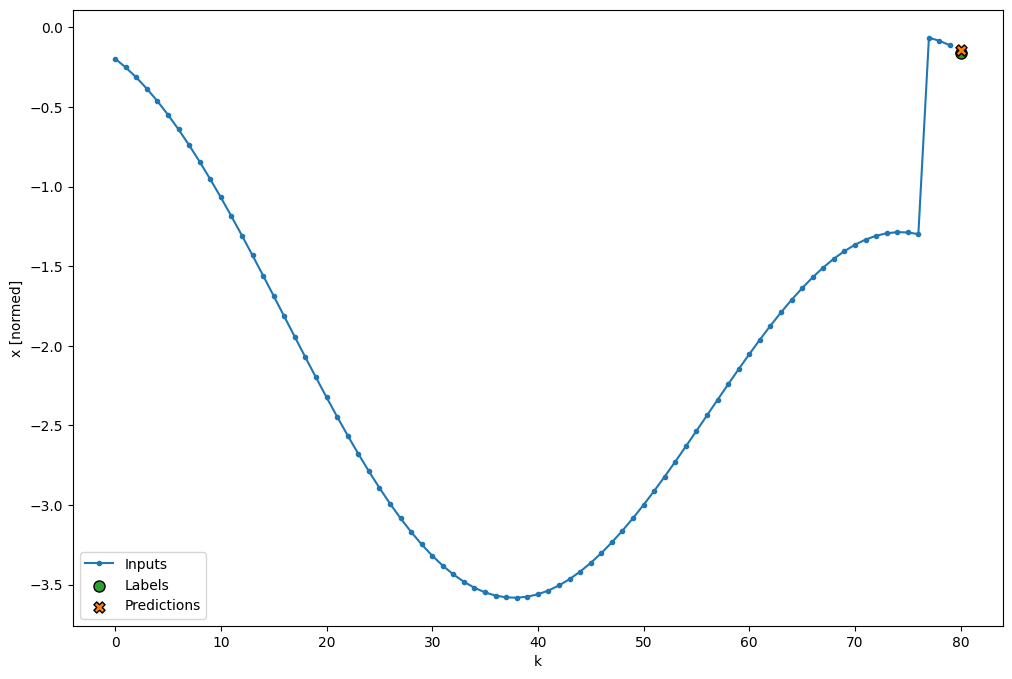

In [270]:
# Choose 6 random indices from X_test
random_indices = random.sample(range(X_test.shape[0]),1)
inputs_chosen_sample = X_test[random_indices]
labels_chosen_sample = y_test[random_indices]
plot(inputs_chosen_sample, labels_chosen_sample, model=model, plot_col='x', max_subplots=3)

In [271]:

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
print(f'Mean Squared Error (MSE): {mse}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test.flatten(), y_pred.flatten())
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 0.026244377717375755
Mean Absolute Error (MAE): 0.06871400028467178


## This model is the best one resulted from last part. but it gives data from 0 to 79 and predict 'x' for range of 1 to 80

### **bold text**## Elman

In [287]:
model  = Sequential()
model.add(keras.layers.SimpleRNN(80, input_shape=(80, 7), activation='relu',return_sequences=True))  # 1 input layer with 71 neurons
model.add(keras.layers.Dense(80 , activation='relu'))
model.add(Dense(1))  # 1 output layer with 1 neuron
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 80, 80)            7040      
                                                                 
 dense_23 (Dense)            (None, 80, 80)            6480      
                                                                 
 dense_24 (Dense)            (None, 80, 1)             81        
                                                                 
Total params: 13601 (53.13 KB)
Trainable params: 13601 (53.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [288]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics ='mse')

In [289]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')

In [290]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks = early_stopping)

Epoch 1/50
2049/2049 [==============================] - 124s 60ms/step - loss: 0.0306 - mse: 0.0306 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 2/50
2049/2049 [==============================] - 122s 60ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 3/50
2049/2049 [==============================] - 123s 60ms/step - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0063 - val_mse: 0.0063
Epoch 4/50
2049/2049 [==============================] - 121s 59ms/step - loss: 0.0026 - mse: 0.0026 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 5/50
2049/2049 [==============================] - 122s 60ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0096 - val_mse: 0.0096
Epoch 6/50
2049/2049 [==============================] - 123s 60ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 7/50
2049/2049 [==============================] - 123s 60ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 8/50
2049/2049 [===================

In [291]:
results = model.evaluate(X_test, y_test)

854/854 [==============================] - 8s 9ms/step - loss: 0.0113 - mse: 0.0113


In [292]:
results = model.evaluate(X_val, y_val)

513/513 [==============================] - 5s 10ms/step - loss: 0.0018 - mse: 0.0018


In [293]:
y_pred = model.predict(X_test)

854/854 [==============================] - 9s 10ms/step


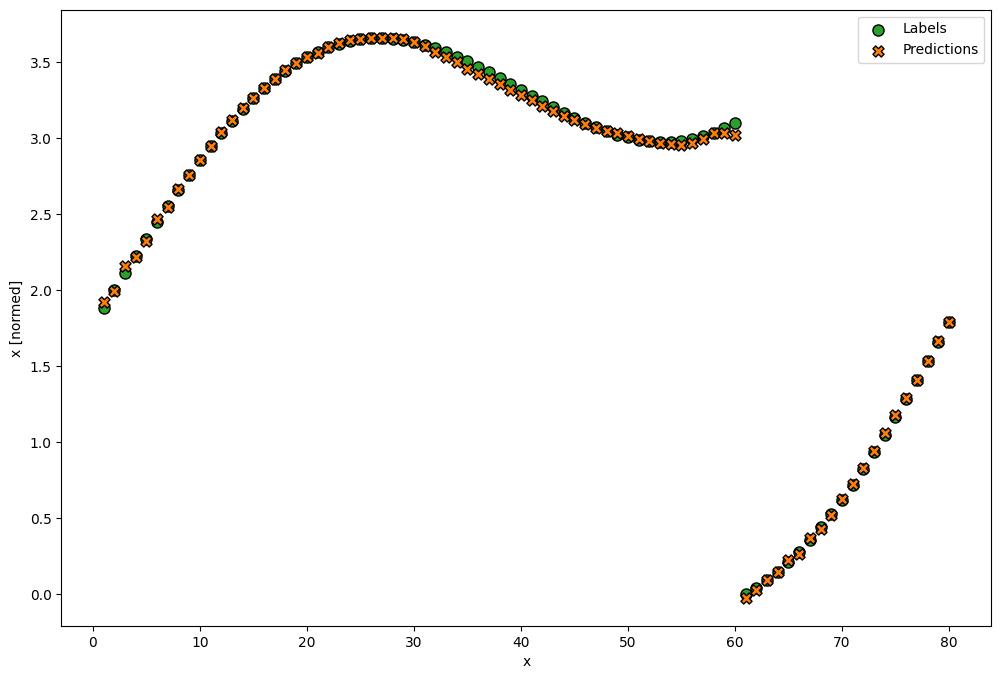

In [357]:
# Choose 6 random indices from X_test
random_indices1 = random.sample(range(X_test.shape[0]),1)

inputs_chosen_sample1 = X_test[random_indices1]
labels_chosen_sample1 = y_test[random_indices1]
plot1(inputs_chosen_sample1, labels_chosen_sample1, model=model, plot_col='x', max_subplots=3)